## Removing Stray Magnetic Fields from the KPLO Magnetometer Measurements

In [1]:
"Import Necessary Libraries"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fcwt

#### February 1st, 2023

In [2]:
"Load Data from KPLO and THEMIS"
kmag = pd.read_csv('KPLO_KMAG_230201_000000_PP_GSE_1sec.csv')
themis = pd.read_csv('20230201_themis_thb_fgm_fgs_l2.csv')

"Convert THEMIS Data to Numpy Arrays"
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th = np.array([Bx_th, By_th, Bz_th])

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z)); B_3b = np.nan_to_num(B_3b)
B_2b = np.vstack((B2_x, B2_y, B2_z)); B_2b = np.nan_to_num(B_2b)
B_1b = np.vstack((B1_x, B1_y, B1_z)); B_1b = np.nan_to_num(B_1b)
B_kplo = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
themis_t = pd.to_datetime(themis['UTC']).to_numpy()
kplo_t = pd.to_datetime(kmag['UTC']).to_numpy()

FileNotFoundError: [Errno 2] No such file or directory: 'KPLO_KMAG_230201_000000_PP_GSE_1sec.csv'

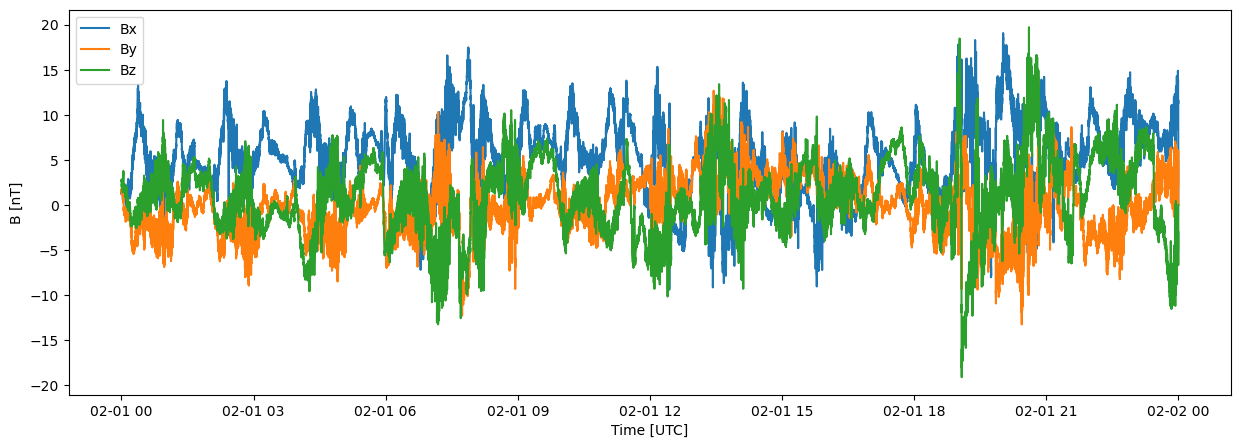

In [3]:
"Plot Noisy Data"
plt.figure(figsize=(15,5))
plt.plot(kplo_t, B_kplo[0].T, label=['Bx', 'By', 'Bz'])
plt.ylabel('B [nT]')
plt.xlabel('Time [UTC]')
plt.legend()


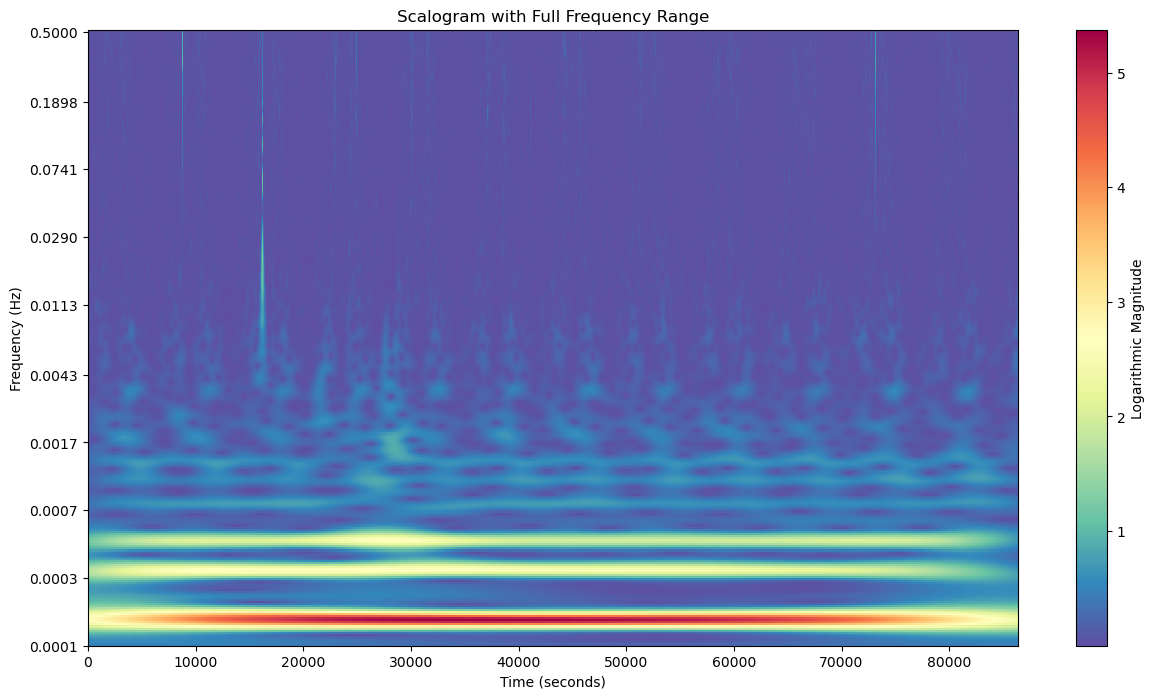

In [5]:
fs = 1 # Hz
f0 = 0.0001 # Hz
f1 = .5 # Hz
freqs, out = fcwt.cwt(B_3b[1]-B_1b[1], fs, f0, f1, fn=300, scaling='log', nthreads=12)

# Plotting
plt.figure(figsize=(15, 8))
ax = plt.gca()
freqs = np.flip(freqs)
# Using 'extent' only for the x-axis and time scaling
extent = [0, out.shape[1] / fs, 0, out.shape[0]]

# Plotting the data
cax = ax.imshow(np.abs(out), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r')

# Creating custom y-ticks to correspond to the logarithmic scale
# Assuming freqs are in ascending order
yticks = np.linspace(0, len(freqs) - 1, 10).astype(int)  # 10 evenly spaced ticks
yticklabels = [f"{freqs[i]:.4f}" for i in yticks]  # Corresponding labels from freqs array

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

plt.colorbar(cax, label='Logarithmic Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Scalogram with Full Frequency Range')
plt.show()

In [5]:
"Calculate Coupling Coefficients"
from magprime.utility import calculate_coupling_coefficients


"Algorithm Parameters"
aii = calculate_coupling_coefficients(B_kplo, fs = 0.1, sspTol=20)

In [6]:
aii

array([9.57860158, 4.77647126, 6.33639601])

In [6]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP


"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = True # Detrend the data
WAICUP.uf = 8640*2 # Number of points in uniform filter (uf)

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(B_kplo), triaxial=True)


c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  waicup_level1[i] = dual(np.vstack((sig[pairs[i][0]], sig[pairs[i][1]])), dt, dj)
c:\Users\alexp\anaconda3\lib\site-packages\magprime\algorithms\WAICUP.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  result[axis] = cleanWAICUP(B[:,axis,:])


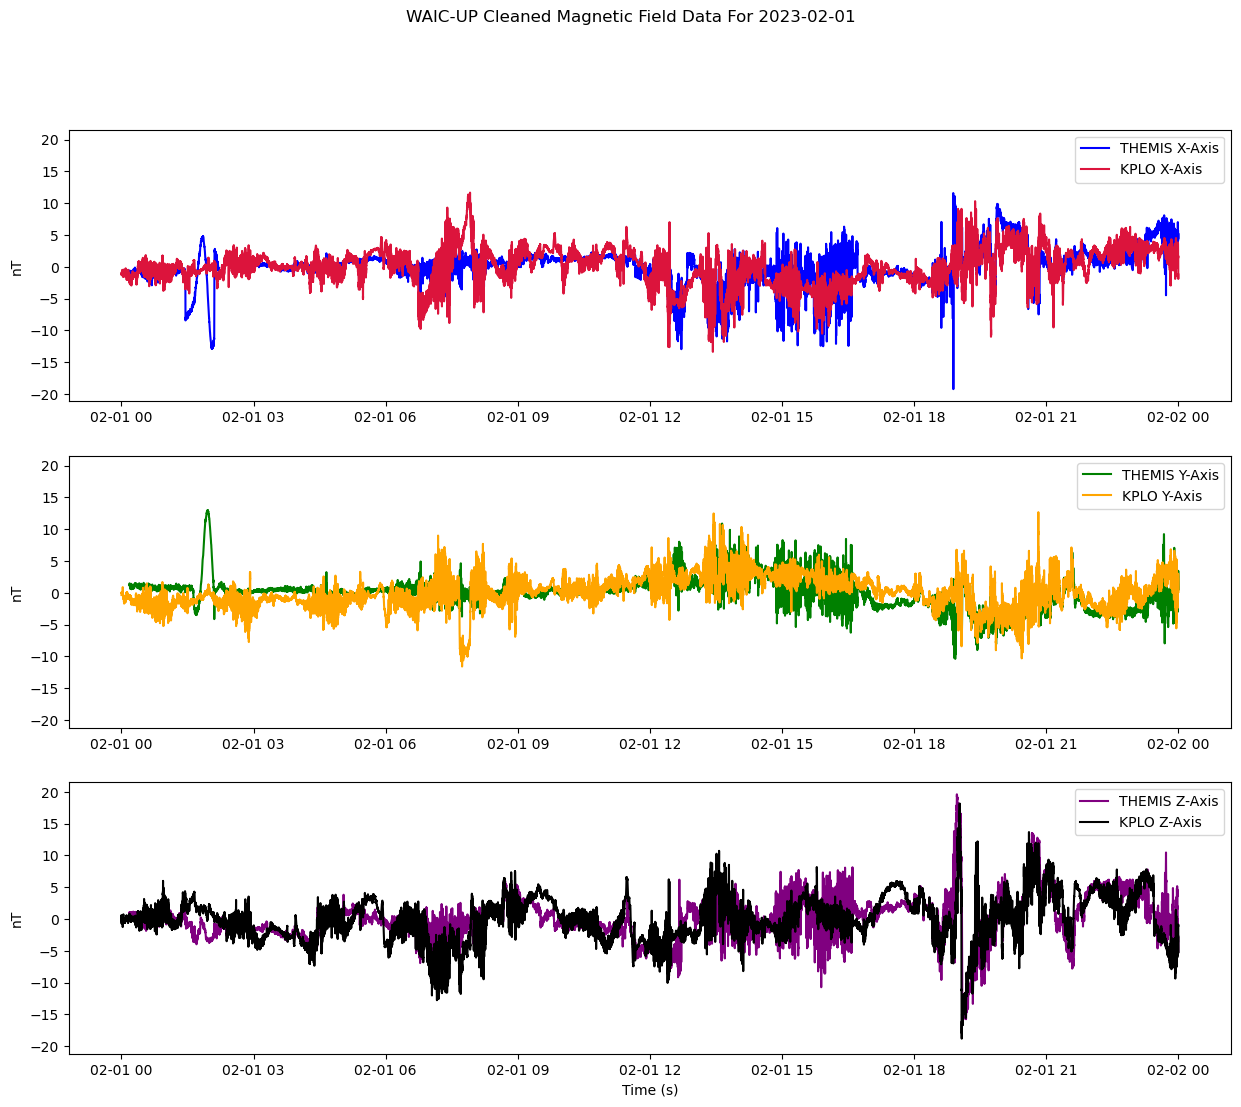

In [7]:
"Plot Data"
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharey=True)
fig.suptitle("WAIC-UP Cleaned Magnetic Field Data For 2023-02-01")

for i in range(3):
    axs[i].plot(themis_t, B_th[i] - np.mean(B_th[i]), label=f"THEMIS {['X', 'Y', 'Z'][i]}-Axis", color = ['blue', 'green', 'purple'][i])
    axs[i].plot(kplo_t, B_WAICUP[i]- np.mean(B_WAICUP[i]), label=f"KPLO {['X', 'Y', 'Z'][i]}-Axis", color = ['crimson', 'orange', 'black'][i])

    axs[i].legend()
    axs[i].set_ylabel("nT")


axs[2].set_xlabel("Time (s)"); 
plt.legend()

ValueError: operands could not be broadcast together with shapes (86400,) (19953,) 

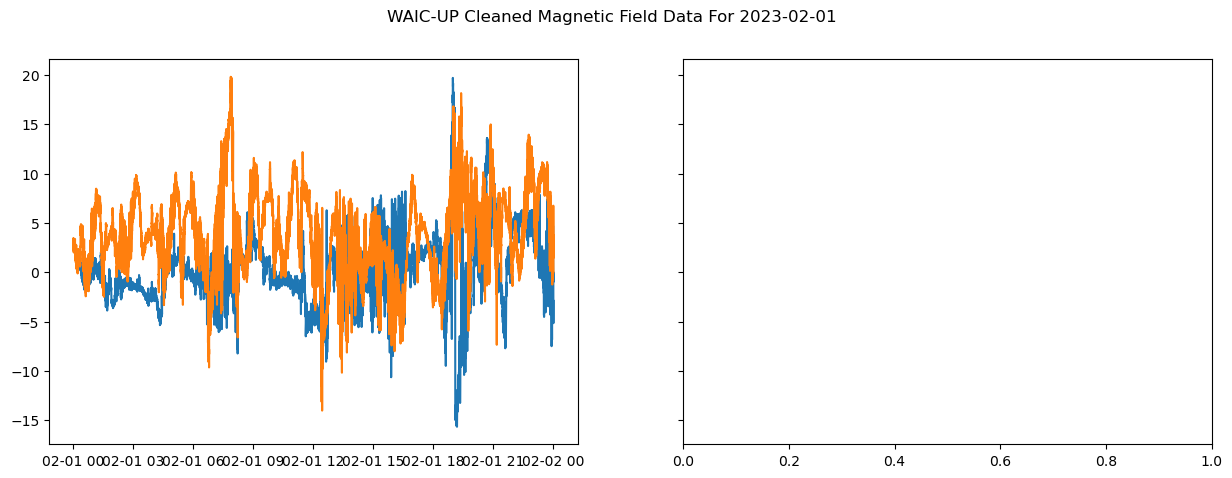

In [7]:
"Plot Data"
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("WAIC-UP Cleaned Magnetic Field Data For 2023-02-01")

axs[0].plot(themis_t, B_th[2], label=f"THEMIS")
axs[0].plot(kplo_t, B_kplo[2,0], label=f"KPLO")

axs[1].plot(themis_t, B_WAICUP[2] - B_th[2], label=f"THEMIS")
axs[1].plot(kplo_t, B_WAICUP[2], label=f"WAIC-UP")

axs[1].set_xlabel("Time (s)"); 
plt.legend()

#### July 6th, 2023

In [22]:
"Load Data from KPLO and THEMIS"
kmag = pd.read_csv('KPLO_KMAG_230706_000000_PP_GSE_1sec.csv')
themis = pd.read_csv('20230706_themis_thb_fgm_fgs_l2.csv')

"Convert THEMIS Data to Numpy Arrays"
Bx_th = themis['bx_gse'].to_numpy(); By_th = themis['by_gse'].to_numpy(); Bz_th = themis['bz_gse'].to_numpy()
B_th2 = np.array([Bx_th, By_th, Bz_th])

"Convert KPLO Data to Numpy Arrays"
B1_x = kmag['MAG1-X'].to_numpy(); B1_y = kmag['MAG1-Y'].to_numpy(); B1_z = kmag['MAG1-Z'].to_numpy()
B2_x = kmag['MAG2-X'].to_numpy(); B2_y = kmag['MAG2-Y'].to_numpy(); B2_z = kmag['MAG2-Z'].to_numpy()
B3_x = kmag['MAG3-X'].to_numpy(); B3_y = kmag['MAG3-Y'].to_numpy(); B3_z = kmag['MAG3-Z'].to_numpy()
B_3b = np.vstack((B3_x, B3_y, B3_z)); B_3b = np.nan_to_num(B_3b)
B_2b = np.vstack((B2_x, B2_y, B2_z)); B_2b = np.nan_to_num(B_2b)
B_1b = np.vstack((B1_x, B1_y, B1_z)); B_1b = np.nan_to_num(B_1b)
B_kplo2 = np.array([B_1b, B_2b, B_3b])

"Extract Timestamps"
themis_t2 = pd.to_datetime(themis['UTC']).to_numpy()
kplo_t2 = pd.to_datetime(kmag['UTC']).to_numpy()

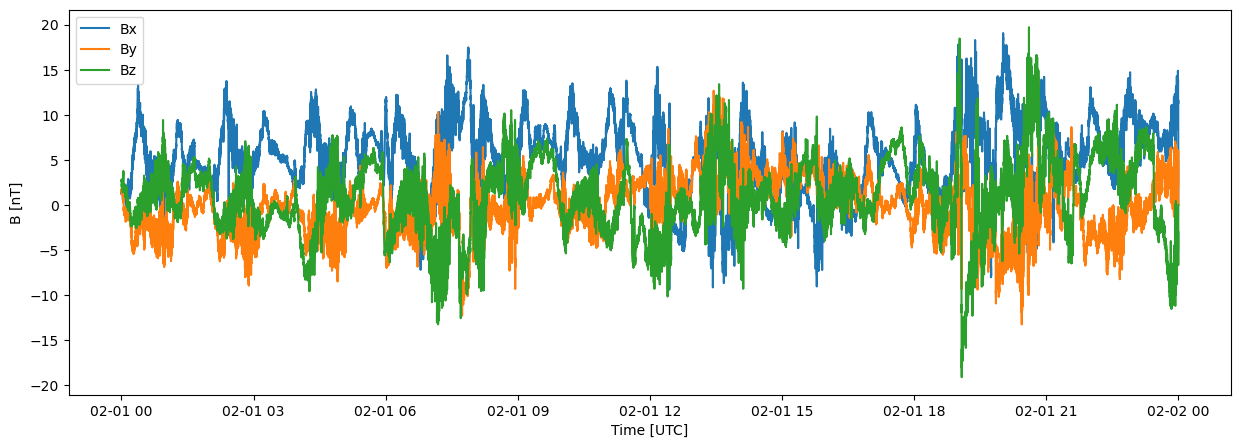

In [16]:
"Plot Noisy Data"
plt.figure(figsize=(15,5))
plt.plot(kplo_t, B_kplo[0].T, label=['Bx', 'By', 'Bz'])
plt.ylabel('B [nT]')
plt.xlabel('Time [UTC]')
plt.legend()


In [18]:
"Apply WAIC-UP"
from magprime.algorithms import WAICUP

"Note: WAIC-UP is not designed to work with low-frequency data due to the Cone of Influence (COI). Detrending is necessary to avoid low-frequency artefacts."
WAICUP.fs = 1 # Sampling Frequency
WAICUP.detrend = True # Detrend the data
WAICUP.uf = 10000 # Number of points in uniform filter (uf)

"Clean the data"
B_WAICUP = WAICUP.clean(np.copy(B_kplo2), triaxial=True)


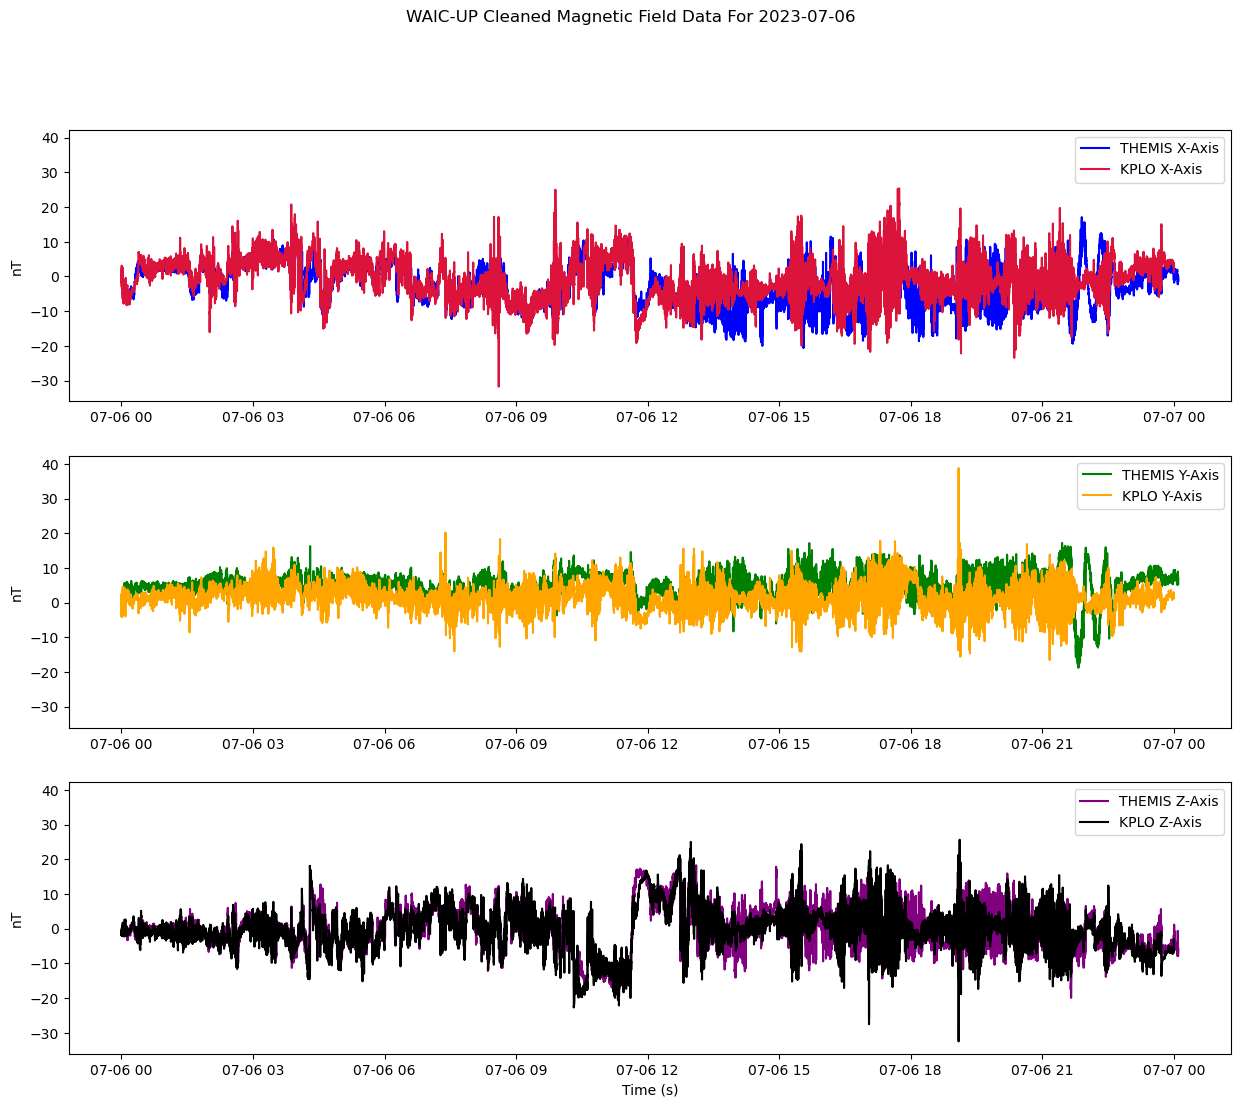

In [24]:
"Plot Data"
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharey=True)
fig.suptitle("WAIC-UP Cleaned Magnetic Field Data For 2023-07-06")

for i in range(3):
    axs[i].plot(themis_t2, B_th2[i], label=f"THEMIS {['X', 'Y', 'Z'][i]}-Axis", color = ['blue', 'green', 'purple'][i])
    axs[i].plot(kplo_t2, B_WAICUP[i], label=f"KPLO {['X', 'Y', 'Z'][i]}-Axis", color = ['crimson', 'orange', 'black'][i])

    axs[i].legend()
    axs[i].set_ylabel("nT")


axs[2].set_xlabel("Time (s)"); 
plt.legend()